In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/ITMO/02_Bright_Field')

In [ ]:
import numpy as np
import os
import datetime
import pandas as pd
import shutil

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

mol = '_008densXL_OvrSmpHard_'

PATCH_SIZE = 256
NUM_CHANNELS = 3
NUM_CLASSES = 1
BATCH_SIZE = 16
NUM_EPOC = 45
dt_tm = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
file_Sig = mol + dt_tm

patches_dir = "/content/gdrive/MyDrive/ITMO/01_BRIGHT_FIELD/857x21"

out_path= '/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_Output_Files/'+file_Sig+'/'
tensor_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_TensorBoard/'+file_Sig+'/'
tensor_log_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_TensorBoard/'+file_Sig+'/log/'
keras_path='/content/gdrive/MyDrive/ITMO/008_OUTPUT/008_Keras/'+file_Sig+"/"

keras_file=keras_path+file_Sig+'.keras'

os.makedirs(os.path.join(out_path, 'images'), exist_ok=True)
os.makedirs(keras_path, exist_ok=True)
os.makedirs(tensor_log_path, exist_ok=True)

print(f"File Signature:{file_Sig} indicates file/folder name")


2025-08-01 07:43:35.543922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754034215.883812      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754034215.976031      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


File Signature: _008densXL_OvrSmpHard_2025-08-01 07:43:52


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, UpSampling2D, BatchNormalization, Activation,
                                     Dropout, Add, Multiply, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import tensorflow.keras.backend as K

# ------------------- Enable Mixed Precision -------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ------------------- Attention Gate -------------------
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same')(g)
    add = Add()([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, (1, 1), padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    out = Multiply()([x, sigmoid])
    return out


# ------------------- Conv Block -------------------
def conv_block(x, filters, dropout_rate=0.1):
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

# ------------------- Decoder Block with Attention -------------------
def decoder_block_attention(x, skip, filters):
    g = UpSampling2D((2, 2))(x)
    att = attention_gate(skip, g, filters // 2)
    x = concatenate([g, att])
    x = conv_block(x, filters)
    return x

# ------------------- Build IAUNet (VGG16) -------------------
def build_iaunet_VERSION_REDUCED(input_shape=(256, 256, 3), num_classes=1, trainable_encoder=False):
    inputs = Input(shape=input_shape)

    # ---- Encoder (VGG16) ----
    vgg = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    vgg.trainable = False #trainable_encoder

    """
    # Freeze first 10 layers and unfreeze last 10 layers
    total_layers = len(vgg.layers)
    print("******",total_layers)
    for i, layer in enumerate(vgg.layers):
        if i < total_layers - 10:  # First layers (except last 10)
            layer.trainable = False
        else:  # Last 10 layers
            layer.trainable = True
    """
    skips = [
        vgg.get_layer("block1_conv2").output,  # 256x256
        vgg.get_layer("block2_conv2").output,  # 128x128
        vgg.get_layer("block3_conv3").output,  # 64x64
        vgg.get_layer("block4_conv3").output   # 32x32
    ]
    bridge = vgg.get_layer("block5_conv3").output  # 16x16

    # ---- Decoder (reduced filters for memory efficiency) ----
    d1 = decoder_block_attention(bridge, skips[3], 256)  # 16 → 32
    d2 = decoder_block_attention(d1, skips[2], 128)      # 32 → 64
    d3 = decoder_block_attention(d2, skips[1], 64)       # 64 → 128
    d4 = decoder_block_attention(d3, skips[0], 32)       # 128 → 256

    # Output (no over-upsampling)
    output = Conv2D(num_classes, (1, 1), activation='sigmoid', dtype='float32', name='segmentation_output')(d4)

    return Model(inputs, output, name='IAUNet_VGG16_T4Friendly')


# Example usage:
model = build_iaunet_VERSION_REDUCED()
print("Total params:", model.count_params())
print("Trainable params:", sum(tf.keras.backend.count_params(p) for p in model.trainable_weights))

# Debug print for attention and IA layers
print("\nAttention layers params:")
for layer in model.layers:
    if 'attn' in layer.name:
        print(f"{layer.name}: {layer.count_params()} params")

print("\nInstance Activation layers params:")
for layer in model.layers:
    if 'ia' in layer.name:
        print(f"{layer.name}: {layer.count_params()} params")


I0000 00:00:1754034365.973938      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754034365.974826      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total params: 18811125
Trainable params: 4094517

Attention layers params:

Instance Activation layers params:


In [ ]:
################---Patch Generator For Training---###################
class PatchDataGenerator(Sequence):
    def __init__(self, image_files, mask_files, indices=None, batch_size=BATCH_SIZE, img_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.img_size = img_size

        if indices is not None:
            self.image_files = [image_files[i] for i in indices]
            self.mask_files = [mask_files[i] for i in indices]
        else:
            self.image_files = image_files
            self.mask_files = mask_files

        self.indices = np.arange(len(self.image_files))

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        Y_batch = []

        for i in batch_indices:
            try:
                x = np.load(self.image_files[i])
                y = np.load(self.mask_files[i])

                if x.shape != (256, 256, 3):
                    print(f"[WARNING] Skipping image {self.image_files[i]} with shape {x.shape}")
                    continue
                if y.shape != (256, 256, 1) and y.shape != (256, 256):  # allow mask to be grayscale
                    print(f"[WARNING] Skipping mask {self.mask_files[i]} with shape {y.shape}")
                    continue
                if y.ndim == 2:  # expand grayscale mask to (H,W,1)
                    y = np.expand_dims(y, axis=-1)

                X_batch.append(x)
                Y_batch.append(y)

            except Exception as e:
                print(f"[ERROR] Failed to load {self.image_files[i]} or {self.mask_files[i]}: {e}")
                continue

        X_batch = np.array(X_batch)
        Y_batch = np.array(Y_batch)

        return X_batch, Y_batch

In [ ]:
################## --- Find Hard Patches ---####################
def find_hard_patches(generator, model, threshold=0.3):
    hard_indices = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        preds = model.predict(x_batch)

        #  Problematic line:
        # error_map = np.abs(preds - y_batch).mean(axis=3)  # <-- only valid if shape is (B, H, W, C)

        #  Fix:
        if preds.ndim == 4:
            error_map = np.abs(preds - y_batch).mean(axis=3)  # Assuming shape: (B, H, W, 1)
        elif preds.ndim == 3:
            error_map = np.abs(preds - y_batch).mean(axis=2)  # (B, H, W)
        else:
            raise ValueError(f"Unexpected prediction shape: {preds.shape}")

        patch_errors = error_map.mean(axis=(1, 2))  # Mean error per image
        for j, err in enumerate(patch_errors):
            if err > threshold:
                hard_indices.append(generator.indices[i * generator.batch_size + j])
    return hard_indices

In [ ]:
################## --- Oversample ---#######################
def oversample_generator(train_indices, hard_patches, multiplier=2):
    """
    Oversample hard patches and combine with train_indices.
    """
    # Ensure they're numpy arrays
    train_indices = np.array(train_indices)
    hard_patches = np.array(hard_patches)

    # Oversample hard patches
    repeated_hard = np.tile(hard_patches, multiplier)

    # Combine and shuffle
    combined = np.concatenate([train_indices, repeated_hard])
    np.random.shuffle(combined)

    return combined.tolist()

In [ ]:
################## ---Metrics and Loss ---####################

def jaccard_score(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_pred = K.round(y_pred)  # Convert probabilities to binary predictions (0 or 1)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())  # Add epsilon to avoid division by zero


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def dice_bce_loss(y_true, y_pred, bce_weight=0.5, smooth=1e-6):
    # Dice Loss
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    # Weighted BCE (no manual weight needed if using class weights)
    bce_loss = K.binary_crossentropy(y_true, y_pred)

    # Combined Loss
    return bce_weight * bce_loss + (1 - bce_weight) * dice_loss

def weighted_binary_crossentropy(y_true, y_pred):
    weight = 10  # Adjust the weight based on the class imbalance
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = weight * y_true * bce + (1 - y_true) * bce
    return K.mean(weighted_bce)


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def boundary_loss(y_true, y_pred):
    # Approximate boundary loss using Laplacian filter on y_pred and y_true
    def laplacian_kernel():
        return tf.constant([[0., 1., 0.],
                            [1., -4., 1.],
                            [0., 1., 0.]], shape=(3, 3, 1, 1), dtype=tf.float32)

    kernel = laplacian_kernel()
    y_true_edge = tf.nn.conv2d(y_true, kernel, strides=1, padding='SAME')
    y_pred_edge = tf.nn.conv2d(y_pred, kernel, strides=1, padding='SAME')
    diff = tf.abs(y_true_edge - y_pred_edge)
    return K.mean(diff)

def focal_dice_boundary_loss(y_true, y_pred, alpha=0.25, gamma=2.0, bce_weight=0.3, boundary_weight=0.1):
    fl = focal_loss(gamma=gamma, alpha=alpha)(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    bl = boundary_loss(y_true, y_pred)
    return bce_weight * fl + (1 - bce_weight - boundary_weight) * dl + boundary_weight * bl

In [ ]:
model = build_iaunet_VERSION_REDUCED()
#for layer in model.layers[-20:]:
    #layer.trainable = True


from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule1 = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=9000, #10000
    decay_rate=0.9
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule1),  # Explicitly set learning rate
    loss= focal_dice_boundary_loss, #dice_bce_loss,  # binary_crossentropy or dice_loss
    metrics=[
        tf.keras.metrics.TruePositives(name="TP"),
        tf.keras.metrics.FalsePositives(name="FP"),
        tf.keras.metrics.TrueNegatives(name="TN"),
        tf.keras.metrics.FalseNegatives(name="FN"),
        'accuracy',
        recall_m,
        precision_m,
        f1_m,
        jaccard_score
    ]
)

In [ ]:
import os

# Known prefixes
PREFIXES = ["C_", "S_", "H_", "g_", ""]  # "" handles plain img_/mask_

# Helper: extract prefix, key, and type (image/mask)
def extract_key_and_prefix(fname, img_or_mask):
    for prefix in PREFIXES:
        img_prefix = f"{prefix}img_" if prefix else "img_"
        mask_prefix = f"{prefix}mask_" if prefix else "mask_"

        if img_or_mask == "img" and fname.startswith(img_prefix):
            return fname.replace(img_prefix, ""), prefix if prefix else "plain"
        elif img_or_mask == "mask" and fname.startswith(mask_prefix):
            return fname.replace(mask_prefix, ""), prefix if prefix else "plain"
    return None, None  # Unrecognized

# Directories
image_dir = os.path.join(patches_dir, 'images')
mask_dir = os.path.join(patches_dir, 'masks')

# Build image dictionary
image_dict = {}
for fname in os.listdir(image_dir):
    if not fname.endswith(".npy"):
        continue
    key, prefix = extract_key_and_prefix(fname, "img")
    if key:
        image_dict[(key, prefix)] = os.path.join(image_dir, fname)

# Build mask dictionary
mask_dict = {}
for fname in os.listdir(mask_dir):
    if not fname.endswith(".npy"):
        continue
    key, prefix = extract_key_and_prefix(fname, "mask")
    if key:
        mask_dict[(key, prefix)] = os.path.join(mask_dir, fname)

# Get matching image-mask pairs
matching_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

# Final aligned file lists
image_files = [image_dict[k] for k in matching_keys]
mask_files = [mask_dict[k] for k in matching_keys]

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
train_indices, val_indices = train_test_split(np.arange(len(image_files)), test_size=0.2, random_state=42)
train_gen = PatchDataGenerator(image_files, mask_files, indices=train_indices, batch_size=BATCH_SIZE)
val_gen   = PatchDataGenerator(image_files, mask_files, indices=val_indices, batch_size=BATCH_SIZE)

In [ ]:
# Callbacks
log_dir = os.path.join(tensor_log_path, "fit_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(keras_file, save_best_only=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=keras_path+file_Sig+"_1st_{epoch:02d}.keras",  # dynamic naming
    save_freq='epoch',
    save_weights_only=False,  # Save the full model (not just weights)
    save_best_only=False,     # Save all epochs (not just the best one)
    verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger( "training_log.csv", append=True)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=NUM_EPOC,
    callbacks=[csv_logger, tensorboard_callback, checkpoint_callback, early_stopping],
    verbose=1,
    #workers=4,
    #use_multiprocessing=True,
    #max_queue_size=10
)
print("First training phase metrics/epochs:")
print(history.history)

Epoch 1/45


I0000 00:00:1754034865.249777      97 service.cc:148] XLA service 0x797dc8001720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754034865.251600      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754034865.251621      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754034867.479518      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-01 07:54:51.954287: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,256,256,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,256,256,32]{3,2,1,0}, f16[32,3,3,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_q

899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - FN: 19856720.0000 - FP: 58594328.0000 - TN: 312761568.0000 - TP: 80646720.0000 - accuracy: 0.8072 - f1_m: 0.6514 - jaccard_score: 0.4906 - loss: 0.3339 - precision_m: 0.5595 - recall_m: 0.8135
Epoch 1: saving model to /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/keras/_008densXL_OvrSmpHard_2025-08-01 07:43:52_1st_01.keras
899/899 ━━━━━━━━━━━━━━━━━━━━ 775s 555ms/step - FN: 19880172.0000 - FP: 58640328.0000 - TN: 313126464.0000 - TP: 80735480.0000 - accuracy: 0.8073 - f1_m: 0.6514 - jaccard_score: 0.4906 - loss: 0.3338 - precision_m: 0.5596 - recall_m: 0.8135 - val_FN: 8359464.0000 - val_FP: 20547418.0000 - val_TN: 165625376.0000 - val_TP: 41397360.0000 - val_accuracy: 0.8775 - val_f1_m: 0.7386 - val_jaccard_score: 0.5876 - val_loss: 0.2456 - val_precision_m: 0.6671 - val_recall_m: 0.8314
Epoch 2/45
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - FN: 22019536.0000 - FP: 30684114.0000 - TN: 340007392.0000 - TP: 79148168.0000 - 

In [ ]:
# --- Mine Hard Patches and Train Again ---

hard_patches = find_hard_patches(train_gen, model, threshold=0.3)
print(f"Oversampling {len(hard_patches)} hard patches...")

# Try oversampling with hard patches
if len(hard_patches) > 0:
    new_train_indices = oversample_generator(train_indices, hard_patches, multiplier=2)
else:
    print("[WARNING] No hard patches found. Using original train_indices.")
    new_train_indices = train_indices

# Final fallback: make sure train indices is not empty
if new_train_indices is None or len(new_train_indices) == 0:
    print("FATAL WARNING: new_train_indices is empty. Falling back to original train_indices.")
    new_train_indices = train_indices


#new_train_indices = oversample_generator(train_indices, hard_patches, multiplier=2)

# Final fallback: make sure train indices is not empty
if new_train_indices is None or len(new_train_indices) == 0:
    print("FATAL WARNING: new_train_indices is empty. Falling back to original train_indices.")
    new_train_indices = train_indices

train_gen_updated = PatchDataGenerator(image_files,mask_files, indices=new_train_indices, batch_size=BATCH_SIZE)



# Log generator status
print(f"[INFO] Final train batches: {len(train_gen)} | Validation batches: {len(val_gen)}")

# Final hard stop to avoid crash
if len(train_gen) == 0:
    raise ValueError("❌ train_gen is empty. Fix your indices or data.")

csv_logger = tf.keras.callbacks.CSVLogger("training_log.csv", append=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
history2 = model.fit(
    train_gen_updated,
    validation_data=val_gen,
    epochs=NUM_EPOC,
    callbacks=[csv_logger, tensorboard_callback, checkpoint_callback, early_stopping],
    verbose=1,
    #workers=4,
    #use_multiprocessing=True,
    #max_queue_size=10
)
print("\nSecond training phase (after hard patch mining) metrics/epochs:")
print(history2.history)

Epoch 1/45
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - FN: 11462833.0000 - FP: 9956440.0000 - TN: 364356032.0000 - TP: 90278192.0000 - accuracy: 0.9552 - f1_m: 0.8933 - jaccard_score: 0.8081 - loss: 0.0967 - precision_m: 0.8998 - recall_m: 0.8879
Epoch 1: saving model to /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/keras/_008densXL_OvrSmpHard_2025-08-01 07:43:52_1st_01.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 155s 171ms/step - FN: 11475455.0000 - FP: 9967239.0000 - TN: 364756640.0000 - TP: 90377280.0000 - accuracy: 0.9552 - f1_m: 0.8933 - jaccard_score: 0.8081 - loss: 0.0967 - precision_m: 0.8998 - recall_m: 0.8879 - val_FN: 7609178.0000 - val_FP: 7645912.0000 - val_TN: 178526848.0000 - val_TP: 42147640.0000 - val_accuracy: 0.9353 - val_f1_m: 0.8451 - val_jaccard_score: 0.7338 - val_loss: 0.1363 - val_precision_m: 0.8455 - val_recall_m: 0.8461
Epoch 2/45
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - FN: 10955668.0000 - FP: 9397626.0000 - TN: 365126016.0000 - TP: 90574216.

In [ ]:
import pandas as pd
df = pd.read_csv("training_log.csv")
print(df.head())

   epoch          FN          FP           TN           TP  accuracy  \
0      0  22923984.0  19761940.0  728121216.0  180251248.0  0.955119   
1      1  21929108.0  18993388.0  728890176.0  181246112.0  0.956972   
2      2  21453250.0  18574888.0  729308288.0  181722016.0  0.957911   
3      3  21063800.0  18243632.0  729639040.0  182111376.0  0.958669   
4      4  20785194.0  18022894.0  729860736.0  182389920.0  0.959194   

       f1_m  jaccard_score      loss  precision_m  ...     val_FN     val_FP  \
0  0.893196       0.807993  0.096626     0.900198  ...  7609178.0  7645912.0   
1  0.897718       0.815290  0.093097     0.904261  ...  8990333.0  5972912.0   
2  0.900035       0.819095  0.091281     0.906525  ...  9051307.0  5757096.0   
3  0.901913       0.822150  0.089784     0.908314  ...  9048254.0  5701845.0   
4  0.903296       0.824406  0.088716     0.909560  ...  7425683.0  7318065.0   

        val_TN      val_TP  val_accuracy  val_f1_m  val_jaccard_score  \
0  178526848.

In [ ]:
import os
# It saves locally in Colab as 'training_log.csv'
local_csv_path = 'training_log.csv'
drive_csv_path = os.path.join(tensor_log_path, f'training_log_{file_Sig}.csv')

if os.path.exists(local_csv_path):
    shutil.copy(local_csv_path, drive_csv_path)
    print(f"Copied existing CSVLogger file to: {drive_csv_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


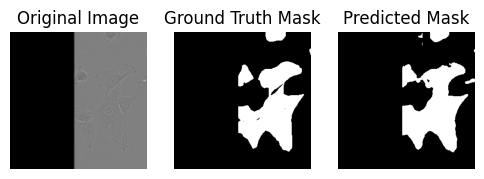

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


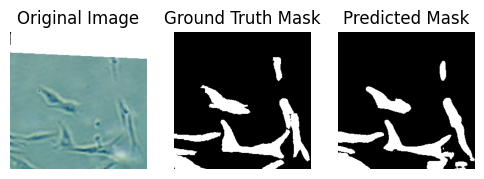

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


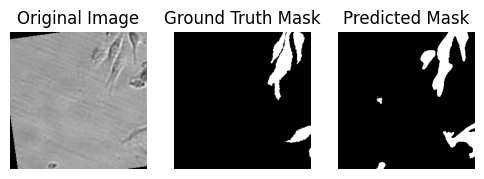

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


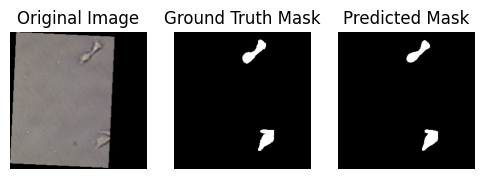

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


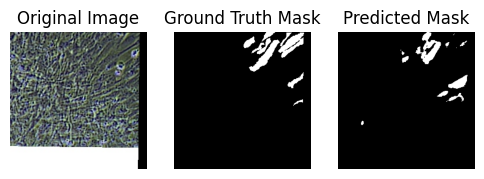

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


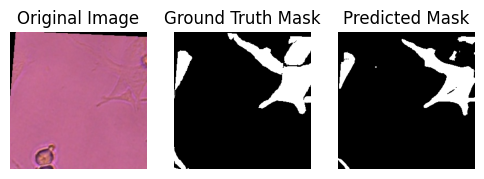

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


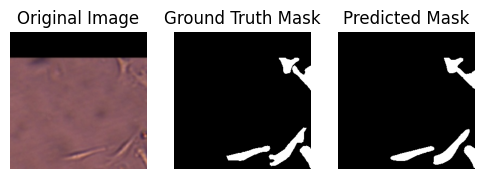

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


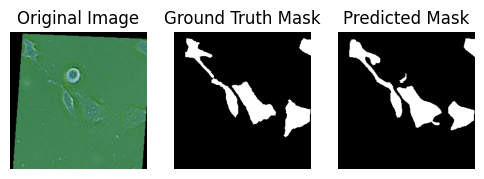

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


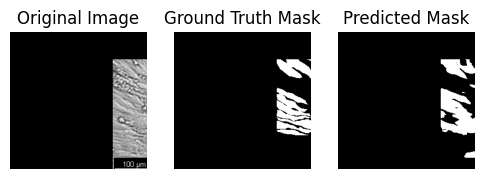

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


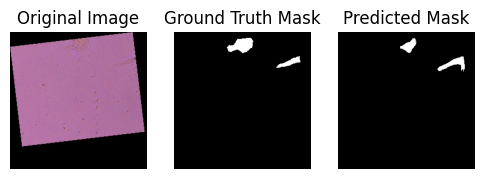

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


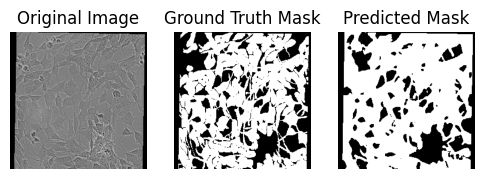

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


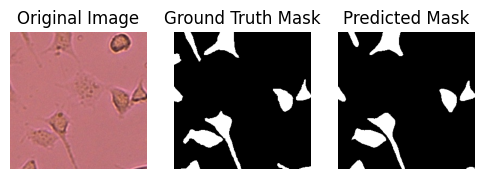

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_12.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


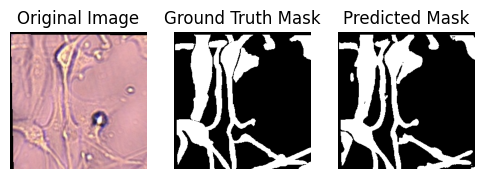

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


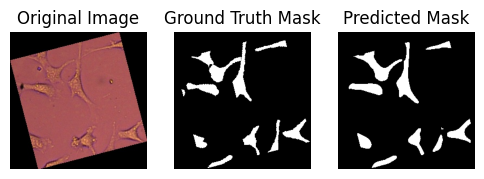

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_14.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


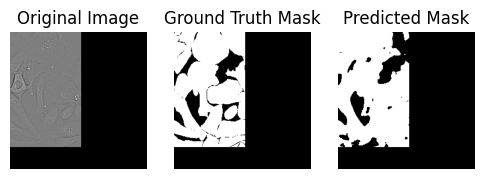

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_15.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


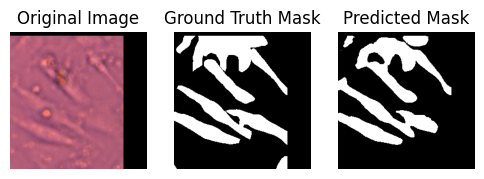

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_16.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


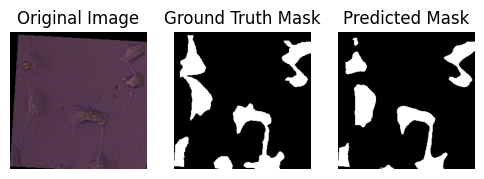

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_17.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


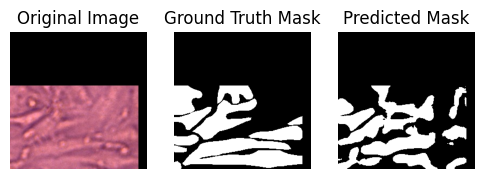

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_18.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


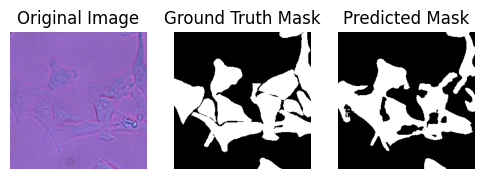

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_19.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


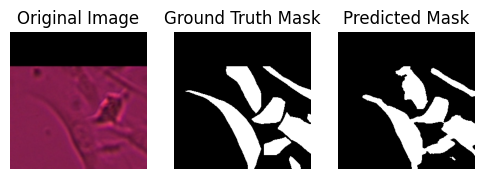

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_20.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


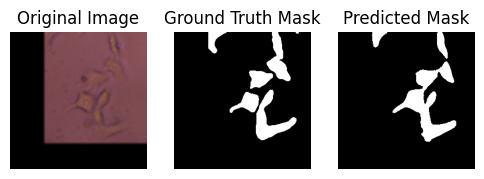

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_21.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


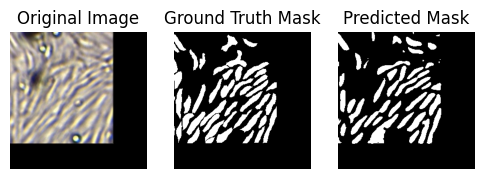

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_22.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


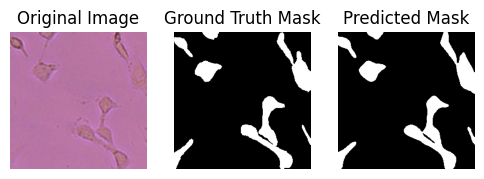

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_23.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


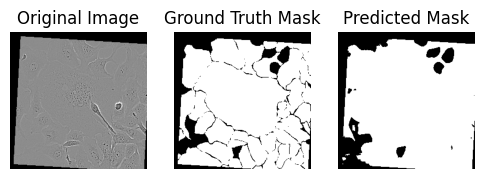

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_24.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


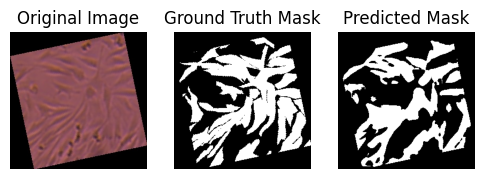

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_25.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


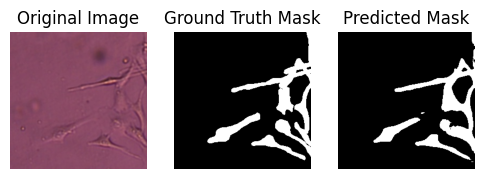

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_26.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


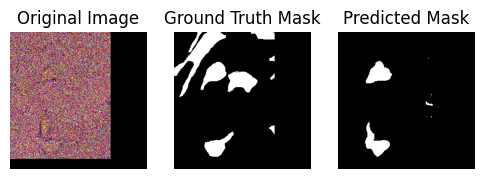

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_27.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


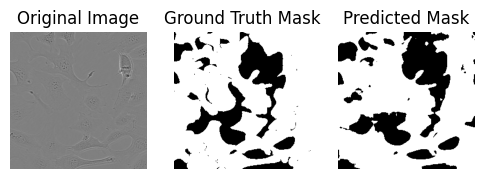

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_28.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


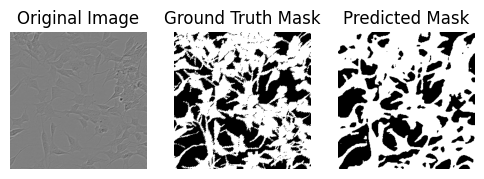

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_29.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


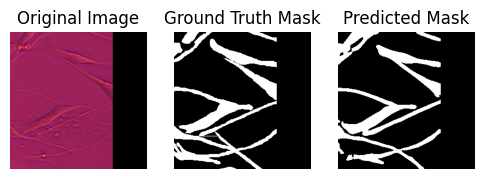

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_30.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


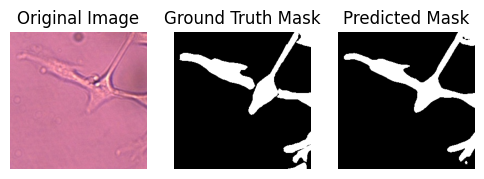

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_31.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


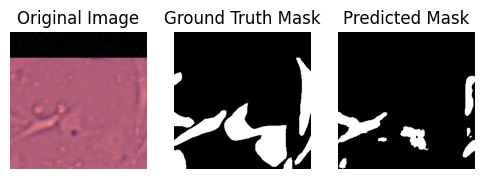

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_32.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


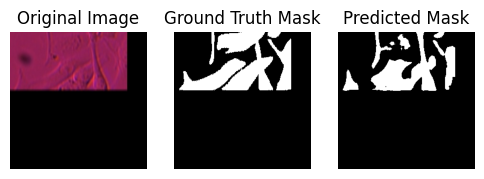

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_33.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


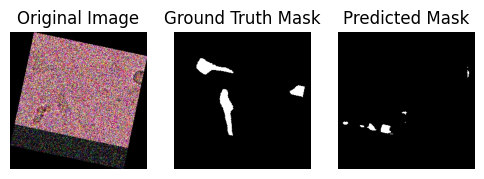

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_34.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


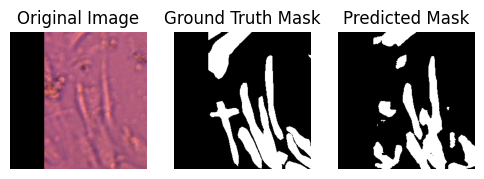

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_35.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


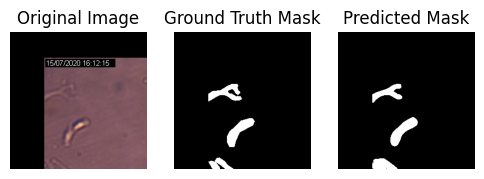

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_36.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


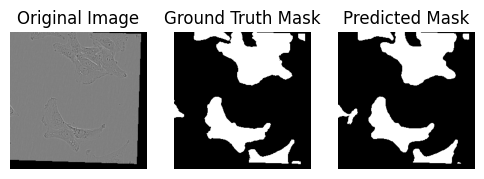

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_37.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


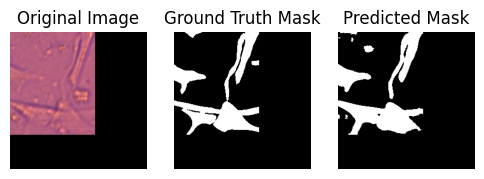

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_38.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


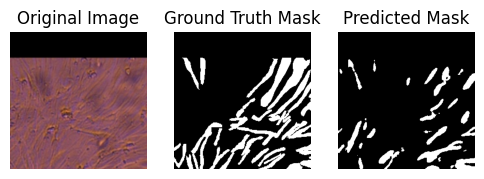

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_39.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


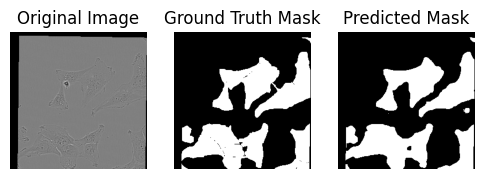

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_40.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


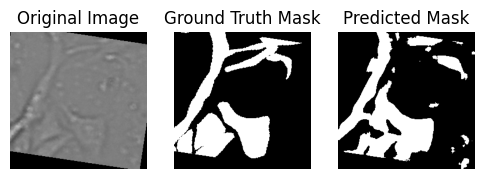

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_41.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


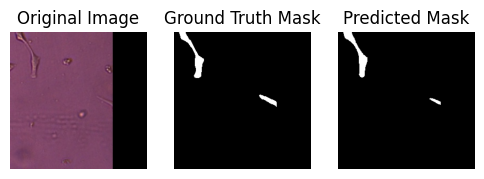

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_42.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


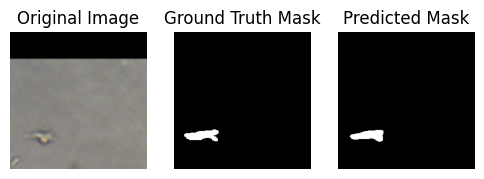

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_43.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


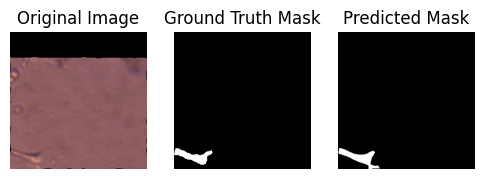

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_44.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


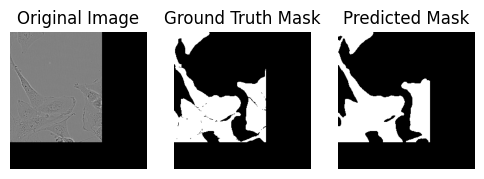

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_45.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


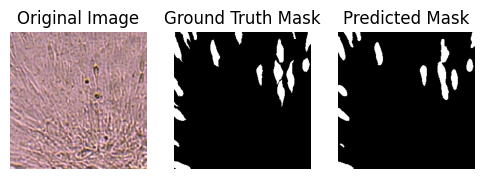

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_46.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


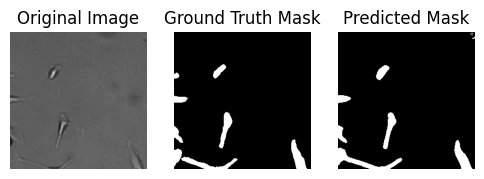

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_47.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


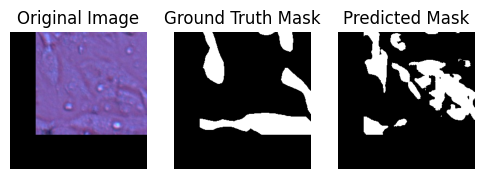

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_48.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


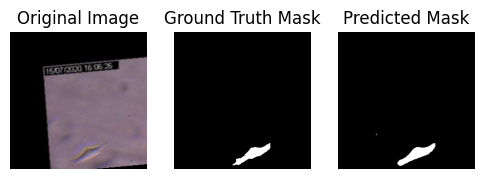

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_49.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


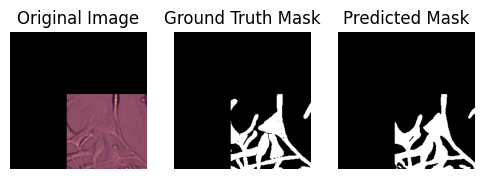

Saved: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52/prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_50.png


In [ ]:
def visualize_predictions(generator, model, num_images=25, save_dir=out_path):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    for i in range(num_images):
        X_batch, Y_batch = generator[i]
        preds = (model.predict(X_batch) > 0.5).astype("int32")

        fig, axs = plt.subplots(1, 3, figsize=(6, 2))

        axs[0].imshow(X_batch[0])
        axs[0].set_title("Original Image")

        axs[1].imshow(Y_batch[0].squeeze(), cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(preds[0].squeeze(), cmap='gray')
        axs[2].set_title("Predicted Mask")

        # Remove axes for clarity
        for ax in axs:
            ax.axis('off')

        # Save figure
        fig_path = os.path.join(save_dir, f"prediction_{file_Sig}_{i+1}.png")
        plt.savefig(fig_path, bbox_inches='tight')
        #plt.close(fig)

        # Display inline
        plt.show(fig)

        # Optional: close to free memory
        plt.close(fig)
        print(f"Saved: {fig_path}")

# Run Visualization
visualize_predictions(val_gen, model, num_images=50)

In [ ]:
import os

out_path = r"/kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52"

print(f"Directory structure of: {out_path}\n")

for root, dirs, files in os.walk(out_path):
    # Indent to show hierarchy
    level = root.replace(out_path, '').count(os.sep)
    indent = '    ' * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = '    ' * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

Directory structure of: /kaggle/working/output/_008densXL_OvrSmpHard_2025-08-01 07:43:52

_008densXL_OvrSmpHard_2025-08-01 07:43:52/
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_22.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_2.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_17.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_16.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_21.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_34.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_32.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_5.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_25.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_50.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_9.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_48.png
    prediction__008densXL_OvrSmpHard_2025-08-01 07:43:52_26.png
    prediction__008densXL_OvrSmpHard_2